In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import userdata
token =userdata.get('Cryptonite-Token')

In [3]:
!git config --global user.email "idantsri2007@gmail.com"
!git config --global user.name "SILETRO"

In [4]:
!git clone https://{token}@github.com/SILETRO/Cryptonite-RTP-Idant.git
%cd Cryptonite-RTP-Idant

Cloning into 'Cryptonite-RTP-Idant'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 90 (delta 24), reused 72 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 1.71 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/Cryptonite-RTP-Idant


In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [24]:
train_dir = path + "/train"
test_dir = path + "/test"

In [25]:
from IPython.testing import test
import tensorflow as tf


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(48,48),
    batch_size=64,
    color_mode='grayscale'
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(48,48),
    batch_size=64,
    color_mode='grayscale'
)


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(48,48),
    batch_size=64,
    color_mode='grayscale'
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


<Axes: ylabel='count'>

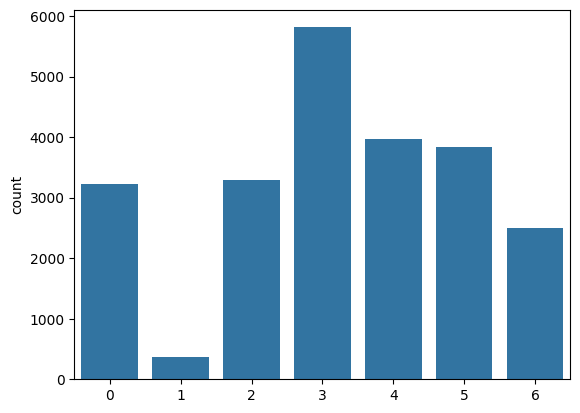

In [26]:
class_names = train_ds.class_names

train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

train_labels = np.array(train_labels)
sns.countplot(x=train_labels)

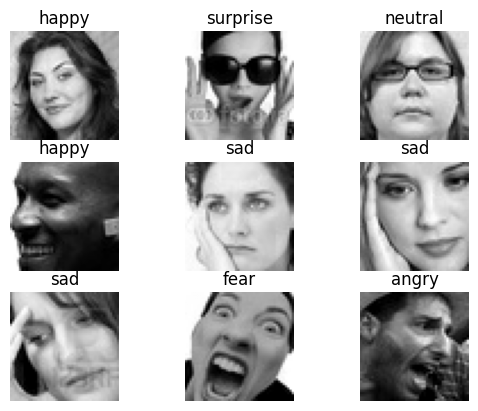

In [29]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")

        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [33]:
from sklearn.utils import class_weight
for _,label in train_ds:
    all_classes = np.concatenate([label],axis=0)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(7),
    y=all_classes
)
class_weights_dict = dict(enumerate(class_weights))

In [34]:
class_weights_dict

{0: np.float64(1.0),
 1: np.float64(8.0),
 2: np.float64(0.8),
 3: np.float64(0.5333333333333333),
 4: np.float64(1.1428571428571428),
 5: np.float64(0.8),
 6: np.float64(1.6)}

In [35]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet',input_shape= (224,224,3))
base_model.trainable = False

In [36]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomRotation(0.05)
])

In [37]:
inputs = tf.keras.Input(shape=(48, 48, 1))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.layers.Concatenate()([x, x, x])
x= tf.keras.applications.efficientnet.preprocess_input(x)
x = data_augmentation(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

model_head = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation='softmax')
])
outputs = model_head(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [38]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='Adam',metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [39]:
history = model.fit(train_ds,epochs=10,class_weight=class_weights_dict,validation_data=val_ds)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 171ms/step - loss: 1.8648 - sparse_categorical_accuracy: 0.2552 - val_loss: 1.5919 - val_sparse_categorical_accuracy: 0.3933
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - loss: 1.6210 - sparse_categorical_accuracy: 0.3708 - val_loss: 1.3975 - val_sparse_categorical_accuracy: 0.4755
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 60s 168ms/step - loss: 1.5500 - sparse_categorical_accuracy: 0.4054 - val_loss: 1.3866 - val_sparse_categorical_accuracy: 0.4755
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - loss: 1.4936 - sparse_categorical_accuracy: 0.4220 - val_loss: 1.3785 - val_sparse_categorical_accuracy: 0.4773
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 60s 167ms/step - loss: 1.4745 - sparse_categorical_accuracy: 0.4257 - val_loss: 1.4613 - val_sparse_categorical_accuracy: 0.4402
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - loss: 1.4371 - sparse_categorical_accuracy: 0.4421 - val_loss: 1.3607 - val_sparse_categorical_acc

In [45]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
  layer.trainable = False
for layer in base_model.layers[-50:]:
  if(not isinstance(layer,tf.keras.layers.BatchNormalization)):
    layer.trainable = True
  else:
    layer.trainable = False

inputs = tf.keras.Input(shape=(48, 48, 1))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.layers.Concatenate()([x, x, x])
x= tf.keras.applications.efficientnet.preprocess_input(x)
x = data_augmentation(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = model_head(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy])

In [46]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 2,508,688 (9.57 MB)

 Non-trainable params: 1,540,883 (5.88 MB)

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
model.fit(train_ds,epochs=50,initial_epoch=len(history.epoch),validation_data=val_ds,class_weight=class_weights_dict,callbacks=[early_stop])

Epoch 11/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 91s 221ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.5070 - val_loss: 1.1668 - val_sparse_categorical_accuracy: 0.5628
Epoch 12/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 68s 189ms/step - loss: 1.1771 - sparse_categorical_accuracy: 0.5396 - val_loss: 1.1547 - val_sparse_categorical_accuracy: 0.5588
Epoch 13/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - loss: 1.0861 - sparse_categorical_accuracy: 0.5706 - val_loss: 1.1254 - val_sparse_categorical_accuracy: 0.5651
Epoch 14/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - loss: 1.0490 - sparse_categorical_accuracy: 0.5845 - val_loss: 1.0587 - val_sparse_categorical_accuracy: 0.5928
Epoch 15/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - loss: 1.0030 - sparse_categorical_accuracy: 0.5998 - val_loss: 1.0641 - val_sparse_categorical_accuracy: 0.5900
Epoch 16/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - loss: 0.9625 - sparse_categorical_accuracy: 0.6135 - val_loss: 1.0468 - val_sparse_categoric

In [48]:
model.evaluate(test_ds)

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - loss: 1.0017 - sparse_categorical_accuracy: 0.6299


[1.0246425867080688, 0.6242685914039612]

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

all_test_labels_list = []
y_pred_probabilities_list = []

for images, labels in test_ds:
    all_test_labels_list.extend(labels.numpy())
    y_pred_probabilities_list.extend(model.predict_on_batch(images))

all_test_labels = np.array(all_test_labels_list)
y_pred = np.array(y_pred_probabilities_list)
y_pred_class = np.argmax(y_pred, axis=1)


Shape of all_test_labels: (7178,)
Shape of y_pred_class: (7178,)


In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

report = pd.DataFrame(classification_report(all_test_labels, y_pred_class, target_names=class_names, output_dict=True)).T


In [83]:
report

,precision,recall,f1-score,support
angry,0.517502,0.570981,0.542928,958.000000
disgust,0.585366,0.648649,0.615385,111.000000
fear,0.539841,0.264648,0.355177,1024.000000
happy,0.881273,0.811725,0.845070,1774.000000
neutral,0.517099,0.711273,0.598839,1233.000000
sad,0.520179,0.465116,0.491109,1247.000000
surprise,0.660324,0.835138,0.737513,831.000000
accuracy,0.624269,0.624269,0.624269,0.624269
macro avg,0.603083,0.615362,0.598003,7178.000000
weighted avg,0.628573,0.624269,0.615066,7178.000000


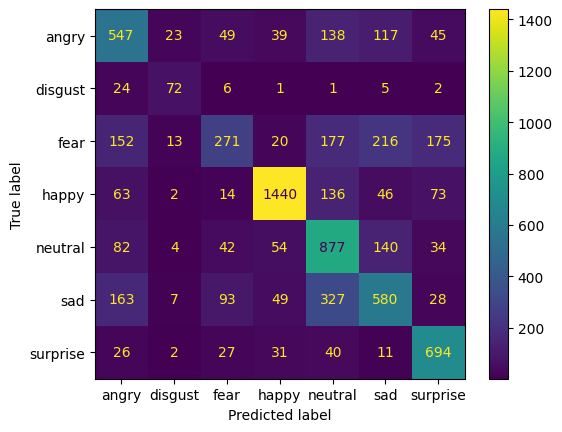

In [84]:
cm = confusion_matrix(all_test_labels, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()